In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.core.framework import graph_pb2
from sklearn.metrics import jaccard_similarity_score

/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X = np.load('combined.npy')
y = np.load('segmented.npy')

In [3]:
print(X.shape, y.shape)

(2000, 64, 84) (2000, 64, 84, 10)


In [4]:
#Shuffle
X,y = shuffle(X,y)

X = X.astype(np.float32)
y = y.astype(np.float32)

In [5]:
# Normalize
X -= 127.0
X /= 127.0

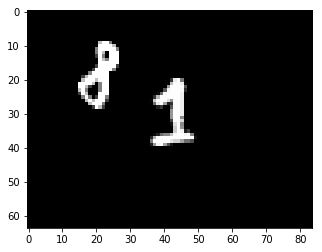

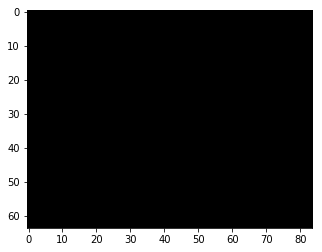

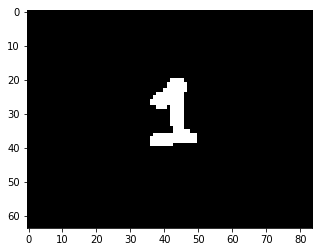

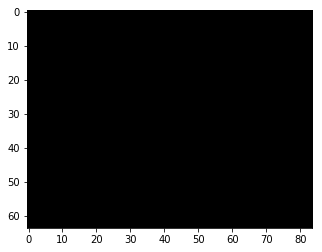

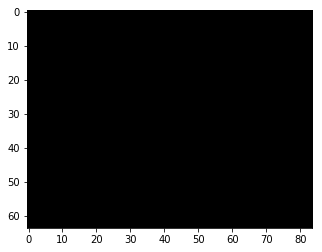

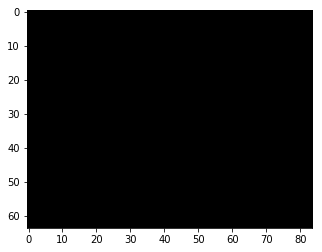

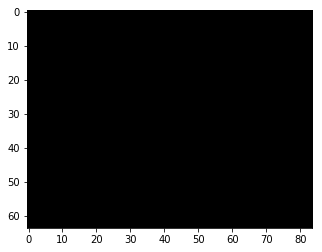

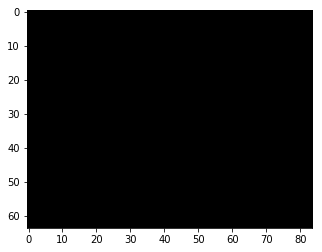

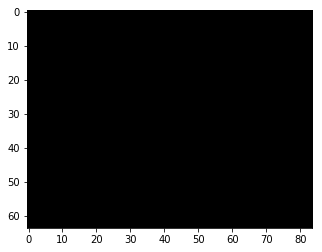

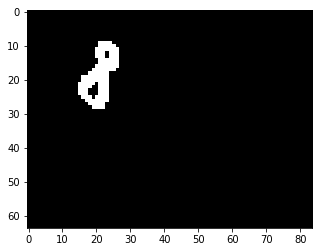

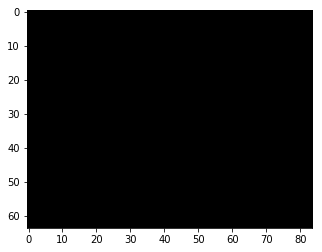

In [6]:
rand_index = np.random.randint(0,len(y))
c,s = X[rand_index], y[rand_index]

plt.imshow(c, cmap='gray')
plt.show()

for i in range(10):
    plt.imshow(s[:,:,i],cmap='gray')
    plt.show()

In [7]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

In [8]:
def get_next_batch(batch_size, X, y):
    for start in range(0,len(y),batch_size):
        end = min(len(y), start+batch_size)
        yield X[start:end] , y[start:end]

In [9]:
num_classes = 10

In [10]:
def load_graph(path_protobuf):
    with open(path_protobuf, "rb") as f:
        graph_def = graph_pb2.GraphDef()
        graph_def.ParseFromString(f.read())
        with tf.Graph().as_default() as graph:
            # Createa new placeholder
            input_big = tf.placeholder(dtype=tf.float32, shape=(None, X.shape[1],X.shape[2],1), name='input_image_big')
            # Import the graph and replace the reshape node with new placeholder.
            tf.import_graph_def(graph_def, name="", input_map={"reshaped_image": input_big})
            return graph

In [11]:
def nn(nb_classes):
    ## Helper functions to reduce clutter.
    _conv1x1 = lambda tensor, nb_filters :\
     tf.layers.conv2d(tensor, 
                    nb_filters, 
                    1, 
                    1, 
                    padding='same',
                    kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))

    _upsample = lambda tensor, kernel_sz, stride, nb_filters :\
     tf.layers.conv2d_transpose(tensor, 
                                nb_filters, 
                                kernel_sz, 
                                stride, 
                                padding='valid',
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))

    # Get all required tensors from our pretrained decoder(CNN).
    encoder = load_graph('checkpoints/frozen_graph.pb')
    with encoder.as_default():
        input_ph = encoder.get_tensor_by_name('input_image_big:0')
        maxpool1_out = encoder.get_tensor_by_name('pool1/MaxPool:0')
        maxpool2_out = encoder.get_tensor_by_name('poool2/MaxPool:0')

        # Create a 32-deep 1x1 convolution layer in place of the 32-wide fully-connected 
        # layer.
        enc_l1 = _conv1x1(maxpool2_out,32)
        # Reduce number of channels to 10.
        enc_l2 = _conv1x1(enc_l1,10)
        enc_l3_1 = _upsample(enc_l2,4,2,nb_classes)
        enc_l3_2 = _conv1x1(maxpool1_out,nb_classes)
        enc_l3 = tf.divide(tf.add(enc_l3_1,enc_l3_2),2)
        
        # Skip connection from first pooling 
        enc_l4 = _upsample(enc_l3,6,2,10)
        
        labels_ph = tf.placeholder(dtype=tf.int32, shape=(None, y.shape[1], y.shape[2], y.shape[3]), name='segmentation_labels')
        lr_ph = tf.placeholder(dtype=tf.float32, name='learning_rate')
        
        logits = tf.reshape(enc_l4,[-1,num_classes], name='logits')
        prediction_op = tf.identity(tf.nn.softmax(enc_l4), name='predictions')
        labels_flat = tf.reshape(labels_ph,[-1,num_classes])
        
        cost_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_flat, logits=logits))
        
        # Apply an optimizer
        optimizer_op = tf.train.AdamOptimizer(learning_rate=lr_ph).minimize(cost_op)

    # Return the graph along with all operation that may be needed.
    # The graph will be passed to tf.Session() because we have added 
    # new opearations to this graph not the default graph
    return encoder, input_ph, labels_ph, lr_ph, optimizer_op, cost_op, prediction_op

In [12]:
new_graph, input_ph, labels_ph, lr_ph, optimizer_op, cost_op, prediction_op = nn(10)

Instructions for updating:
Use the retry module or similar alternatives.


/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: Deprecat

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: Deprecat

In [13]:
print(prediction_op.shape)

(?, 64, 84, 10)


In [14]:
def eval_cost(cost_op, X, y, batch_sz):
    total_cost = 0
    nb_batches = 0
    for batch_X,batch_y in get_next_batch(batch_size,X,y):
        batch_X = np.expand_dims(batch_X,3)
        feed_dict={input_ph: batch_X, labels_ph: batch_y}
        total_cost += cost_op.eval(feed_dict=feed_dict)
        nb_batches += 1
    return total_cost / nb_batches

def eval_IoU(prediction_op, X, y, batch_sz):
    nb_batches = 0
    total_iou = 0
    for batch_X, batch_y in get_next_batch(batch_sz,X,y):
        batch_X = np.expand_dims(batch_X,3)
        feed_dict={input_ph: batch_X, labels_ph: batch_y}
        predictions = prediction_op.eval(feed_dict=feed_dict)
        total_iou += jaccard_similarity_score(batch_y.flatten(),predictions.flatten()>0.5)
        nb_batches += 1
    return 100*total_iou/nb_batches

In [15]:
from tqdm import tqdm

epochs = 75
batch_size = 512
learning_rate = 0.001
batches_per_epoch = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)



# Launch the graph
with tf.Session(graph=new_graph) as sess:
    summary_writer = tf.summary.FileWriter('./mnist-fcn',sess.graph)
    summary_writer.flush()
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(epochs)):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        

        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all training batches
        for x, y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            # Convert x to a 4D Tensor by adding an empty dimension because
            # The placeholder and the convolution layers expect a 4-D Tensor
            # in [N,W,H,C] format.
            x_ = np.expand_dims(x,3)
            sess.run(optimizer_op, 
                     feed_dict={input_ph:x_, labels_ph:y, lr_ph:learning_rate})
        
        if (epoch+1) % 5 == 0:
            training_cost = eval_cost(cost_op, X_train_fold, y_train_fold, batch_size)
            training_IoU  = eval_IoU(prediction_op, X_train_fold, y_train_fold, batch_size)
            valid_IoU  = eval_IoU(prediction_op, X_val_fold, y_val_fold, batch_size)
            test_IoU  = eval_IoU(prediction_op, X_test, y_test, batch_size)
            #print(training_cost, training_acc, valid_acc, test_acc)
            
            summary = tf.Summary()
            summary.value.add(tag="Train Cost", simple_value=training_cost)
            summary.value.add(tag="Train IoU", simple_value=training_IoU)
            summary.value.add(tag="Validation IoU", simple_value=valid_IoU)
            summary.value.add(tag="Test IoU", simple_value=test_IoU)
            summary_writer.add_summary(summary,epoch+1)
            summary_writer.flush()

    
    print("Optimization Finished!")
    summary_writer.close()
    # Save the graph structure only.
    # Need to save weights in a checkpoint file separately.
    # The graph structure is saved twice, once as a text file 
    # with extension '.pbtxt' and then as a binary file with 
    # extension '.pb'. This is done for demonstration only.
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist-fcn.pbtxt',
    as_text=True)
    
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist-fcn.pb',
    as_text=False)
    
    saver = tf.train.Saver()
    saver.save(sess,'./checkpoints/mnist-fcn.ckpt',epoch+1)

100%|██████████| 75/75 [07:25<00:00,  5.93s/it]


Optimization Finished!
